# Arima-X forecasting


Arima X is a time series forecasting model defined by the function `ARIMA(d, p, q)`


In this notebook, we will
1. Derive the best parameters for the model (p, q, and d)
2. Train a model with these parameters and our existing dataset
3. Evaluate the performance of the model

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

In [14]:
data = pd.read_csv('../datasets/one_hot_encoded/combined-data.csv').groupby("Year", as_index=False).mean()

## Deriving the Parameters

In order to derive the parameters for our ARIMA model, we will use the **Augmented Dickey-Fuller Test**

In [15]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(data["Temperature"])

print("ADF Statistic:", result[0])
print("P-Value: ", result[1])
print('Critical Values:')
for key, value in result[4].items():
  print('\t%s: %.3f' % (key, value))

ADF Statistic: 0.32847081202348694
P-Value:  0.978613659739638
Critical Values:
	1%: -3.575
	5%: -2.924
	10%: -2.600


In this situation, our P-value is > 0.05, which means that we reject the null hypothesis. i.e this dataset is non-stationary,
plotting the data proves this

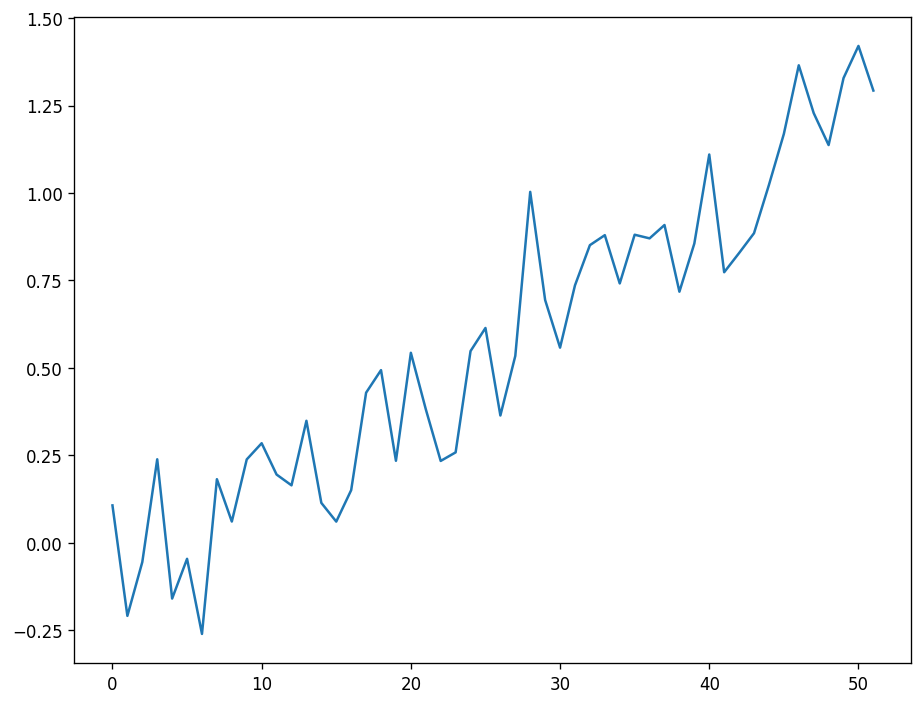

In [16]:
plt.plot(data["Temperature"])

Our data steadily climbs, i.e is non-stationary, so we need to differentiate

In [49]:
diff = data.diff().dropna()

result = adfuller(diff["Temperature"])

print("ADF Statistic:", result[0])
print("P-Value: ", result[1])
print('Critical Values:')
for key, value in result[4].items():
  print('\t%s: %.3f' % (key, value))

ADF Statistic: -7.684292613618476
P-Value:  1.4756444943196828e-11
Critical Values:
	1%: -3.575
	5%: -2.924
	10%: -2.600


Our p-value for the differentiated dataset is <0.05, and thus we can accept our null hypothesis that this dataset is stationary


Plotted below are differences 0->2

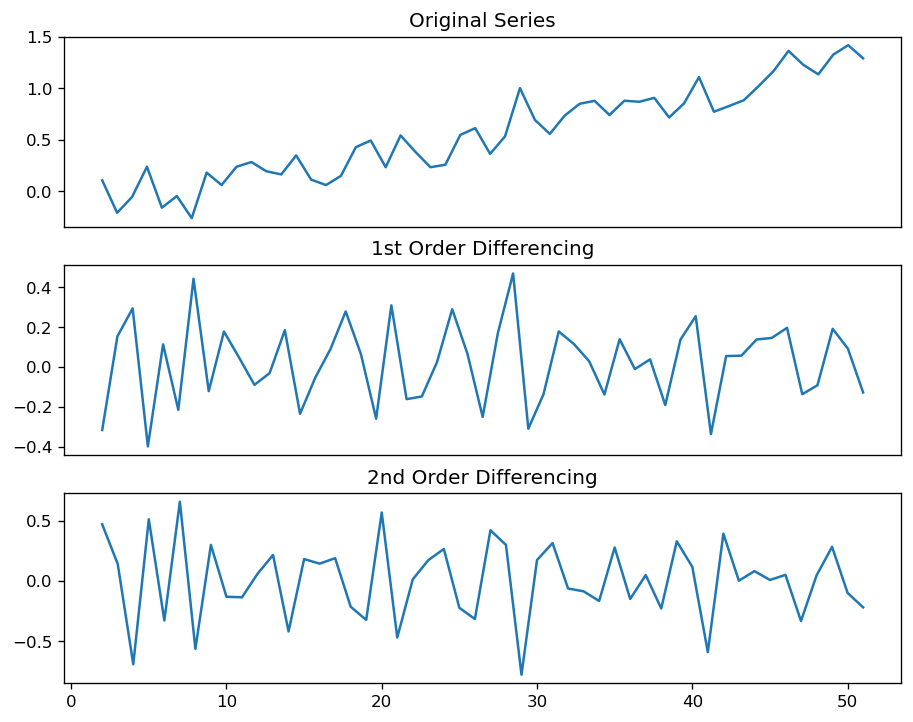

In [50]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})
 
# Original Series
fig, (ax1, ax2, ax3) = plt.subplots(3)
ax1.plot(data["Temperature"]); ax1.set_title('Original Series'); ax1.axes.xaxis.set_visible(False)
# 1st Differencing
ax2.plot(data["Temperature"].diff()); ax2.set_title('1st Order Differencing'); ax2.axes.xaxis.set_visible(False)
# 2nd Differencing
ax3.plot(data["Temperature"].diff().diff()); ax3.set_title('2nd Order Differencing')
plt.show()

We can also use autocorrelation to demonstrate the nature of the data as we difference it

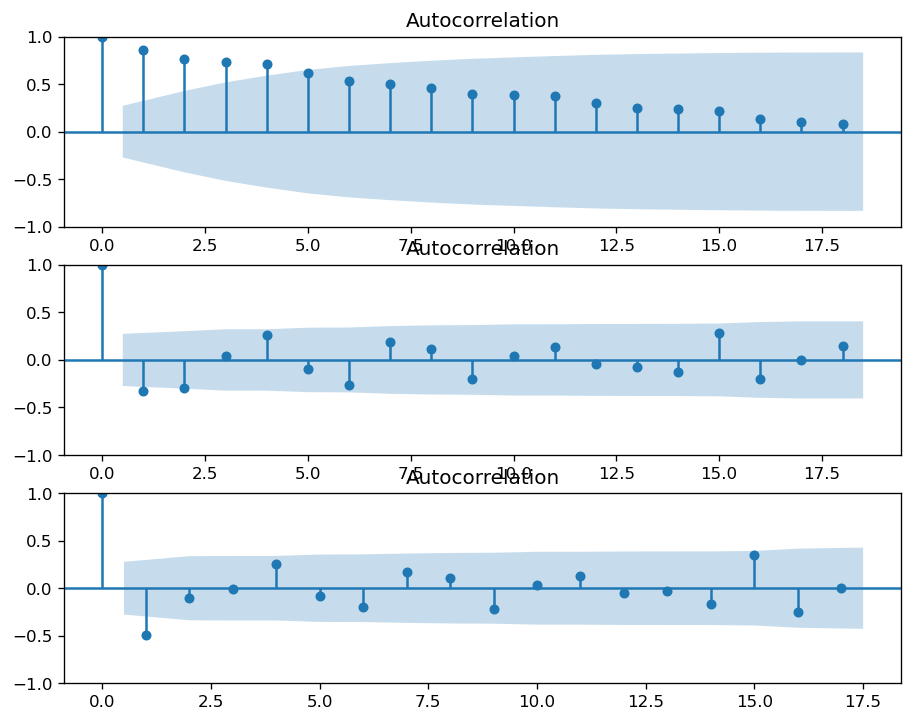

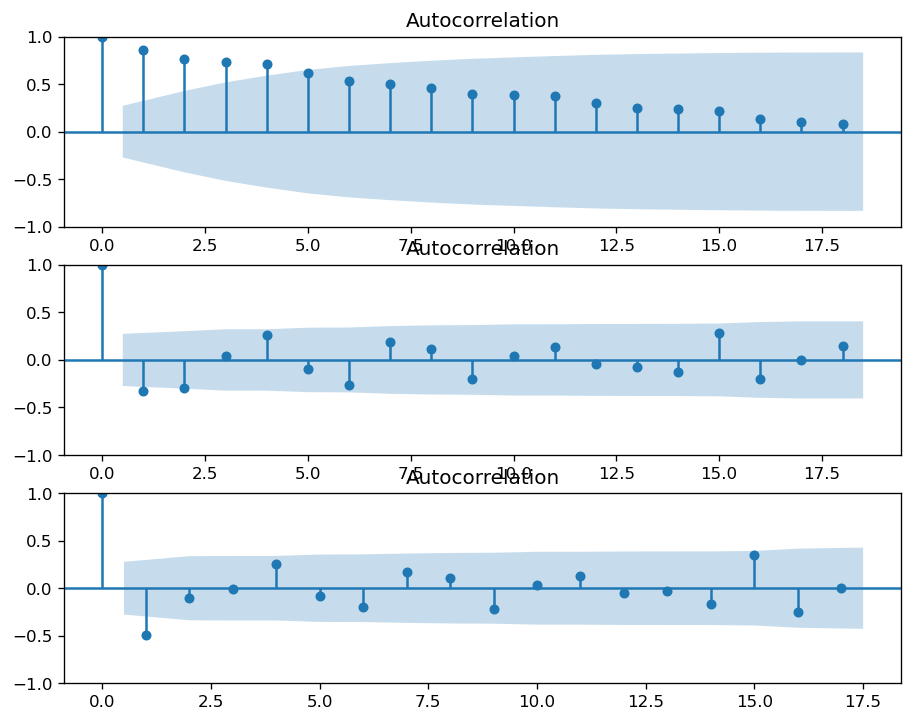

In [51]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, (ax1, ax2, ax3) = plt.subplots(3)
plot_acf(data["Temperature"], ax=ax1)
plot_acf(data["Temperature"].diff().dropna(), ax=ax2)
plot_acf(data["Temperature"].diff().diff().dropna(), ax=ax3)

So, we use 1 for the d parameter of ARIMA-X

In order to find the value for p, we use partial autocorrelation


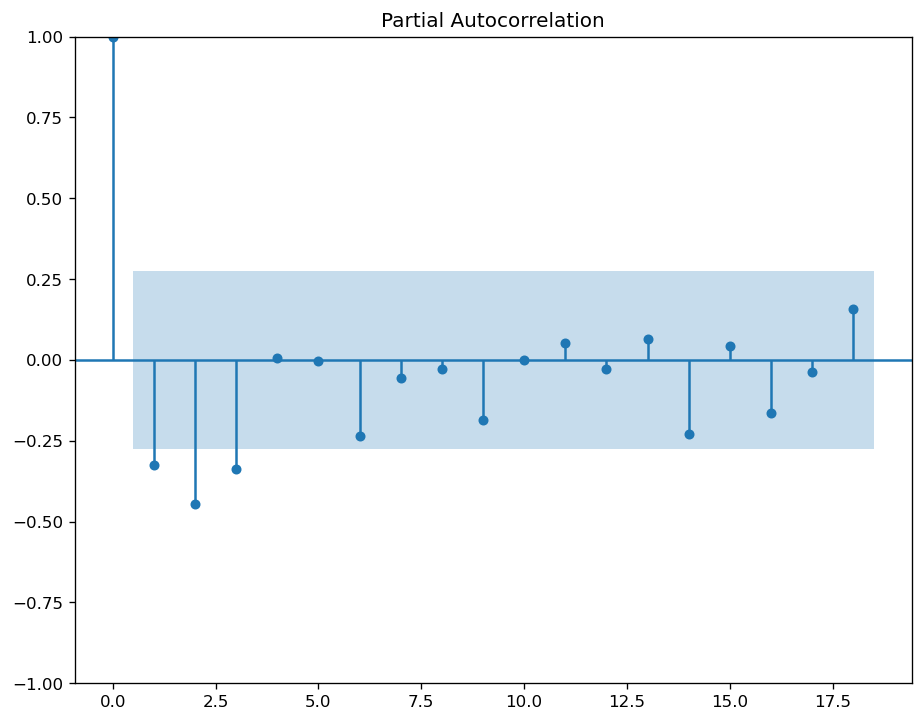

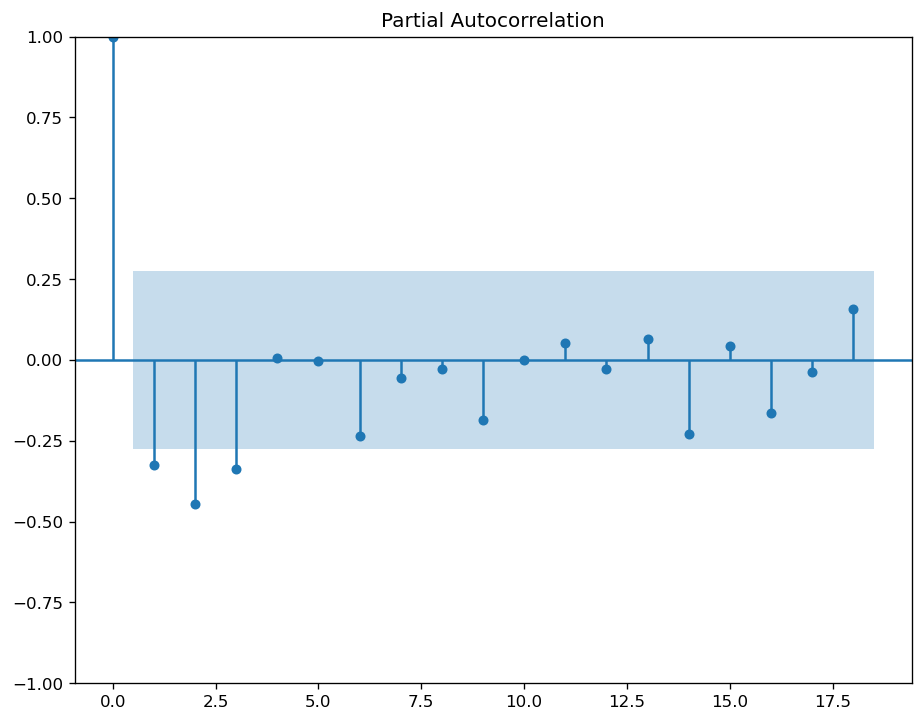

In [52]:
# fig, (ax1, ax2, ax3) = plt.subplots(3)
# plot_pacf(data["Temperature"], ax=ax1)
plot_pacf(data["Temperature"].diff().dropna())
# plot_pacf(data["Temperature"].diff().diff().dropna(), ax=ax3)

As we can see, the first lag is by far the most significant, and thus we use p = 1

In order to find the q value, we count the number of lags outside of the significance limit in the autocorrelation graph of the 1st differential, we have about 3 lags outside of this limit, and thus we choose 3 for our q value

## Training

Now that we have all the ARIMA parameters, we now train our ARIMA model as ARIMA(1, 1, 3)

We use the Co2 levels as an exogenous / explanatory variable, because there is a strong correlation between Co2 levels and temperatures

We also normalize the Co2 level to be closer to the values for Temperature, to prevent strange behavior with the model

In [109]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split

scaler = max(data["Temperature"]) / max(data["Co2"])

data["Co2"] = data["Co2"] * scaler

d = 1
p = 1
q = 3

train_data, test_data = train_test_split(data, shuffle=False, test_size=0.3)

arima_model = ARIMA(train_data.Temperature, order=(p, d, q), exog=train_data.Co2)
model = arima_model.fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:            Temperature   No. Observations:                 4804
Model:                 ARIMA(1, 1, 3)   Log Likelihood               -2317.491
Date:                Thu, 21 Mar 2024   AIC                           4646.982
Time:                        01:57:01   BIC                           4685.844
Sample:                             0   HQIC                          4660.630
                               - 4804                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Co2            0.0145      0.027      0.529      0.597      -0.039       0.068
ar.L1         -0.8037      0.347     -2.317      0.020      -1.483      -0.124
ma.L1         -0.1189      0.348     -0.342      0.7

## Model Evaluation

We now have a fully trained ARIMA-X model that uses Co2 levels in order to aid its predictions

We will do the following:
1. Look at how the model predicts values its seen before
2. Look at how the model predicts values its never seen before

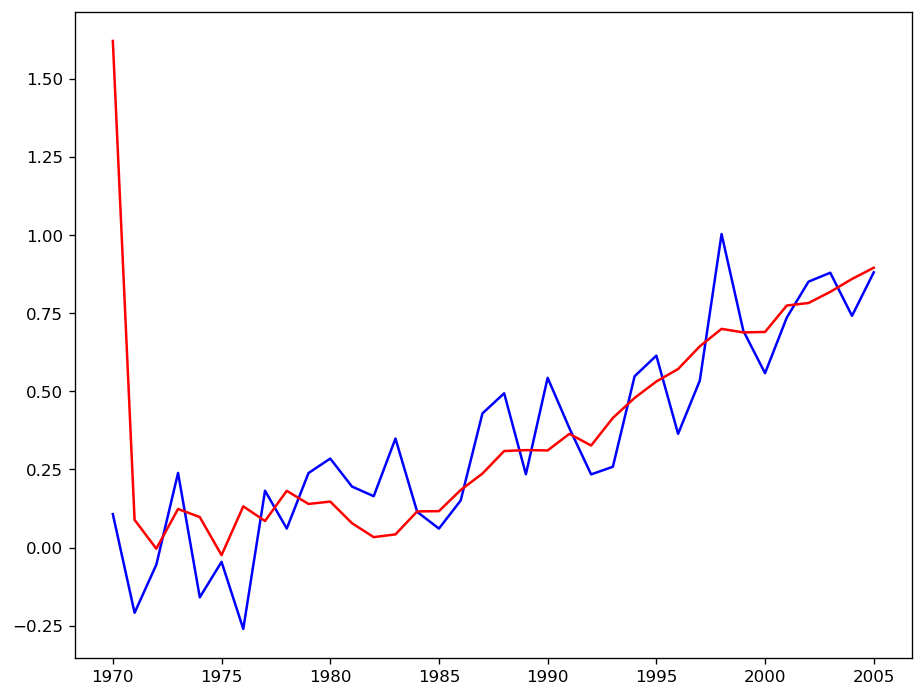

In [99]:
p = model.predict()

plt.plot(train_data.Year, train_data.Temperature, color="blue")
plt.plot(p.index + 1970, p.tolist(), color="red")

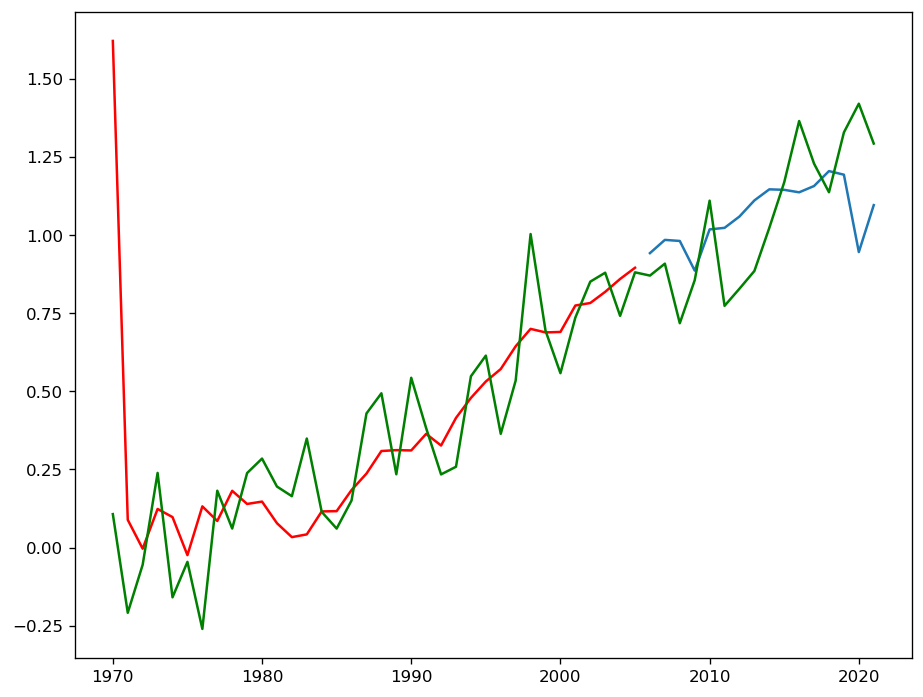

In [100]:
forecast = model.forecast(steps=len(test_data), exog=test_data.Co2)

# Plot the forecasted / test data
plt.plot(forecast.index+1970, forecast)

# plot the previously trained data as interpreted by the model
plt.plot(p.index+1970, p.tolist(), color="red")


plt.plot(data.Year, data.Temperature, color="green")


In [97]:
# Determine the accuracy of the future predictions based on the actual data we have for the future

from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

rmse = sqrt(mean_squared_error(test_data.Temperature, forecast))
r2 = r2_score(test_data.Temperature, forecast)

print("RMSE of forecast: ", rmse)
print("R2 of forecast: ", r2)

RMSE of forecast:  0.16524066886129415
R2 of forecast:  0.4422775580750372


As you can see above, we have the error values for our model


Out of curiosity, we have trained an ARIMA-X model with the same parameters for each country independently

In [102]:
data = pd.read_csv('../datasets/one_hot_encoded/combined-data.csv') 


countries = [c.removeprefix("Country_") for c in data.columns if c.startswith("Country_")]

In [164]:
models = {}

for country in countries:
    cdata = data.query(f"`Country_{country}` == 1")
    cdata.set_index("Year", inplace=True)
    model = ARIMA(cdata.Temperature, order=(p, d, q), exog=cdata.Co2)

    models[country] = {
        "model": model.fit(),
        "data": cdata
    }

/opt/anaconda/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self.

In [165]:

errors = {}

for country in countries:
    model = models[country]["model"]
    cdata = models[country]["data"]

    forecast = model.forecast(steps=52, exog=cdata.Co2)

    rmse = sqrt(mean_squared_error(cdata.Temperature, forecast))
    r2 = r2_score(cdata.Temperature, forecast)
    errors[country] = {
        "rmse": rmse,
        "r2": r2
    }



/opt/anaconda/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/opt/anaconda/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_predicti

In [166]:
# Find the country that has the best RMSE
best_country_rmse = min(errors, key=lambda x: errors[x]["rmse"])
best_country_r2 = max(errors, key=lambda x: errors[x]["r2"])

print("Best country (rmse): ", best_country_rmse)
print("RMSE: ", errors[best_country_rmse]["rmse"])
print("R2: ", errors[best_country_rmse]["r2"])
print()
print("Best country (r2): ", best_country_r2)
print("RMSE: ", errors[best_country_r2]["rmse"])
print("R2: ", errors[best_country_r2]["r2"])

Best country (rmse):  Indonesia
RMSE:  0.21005854179047329
R2:  0.6906729134697387

Best country (r2):  Philippines
RMSE:  0.21136541543216394
R2:  0.776160104147852


/opt/anaconda/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


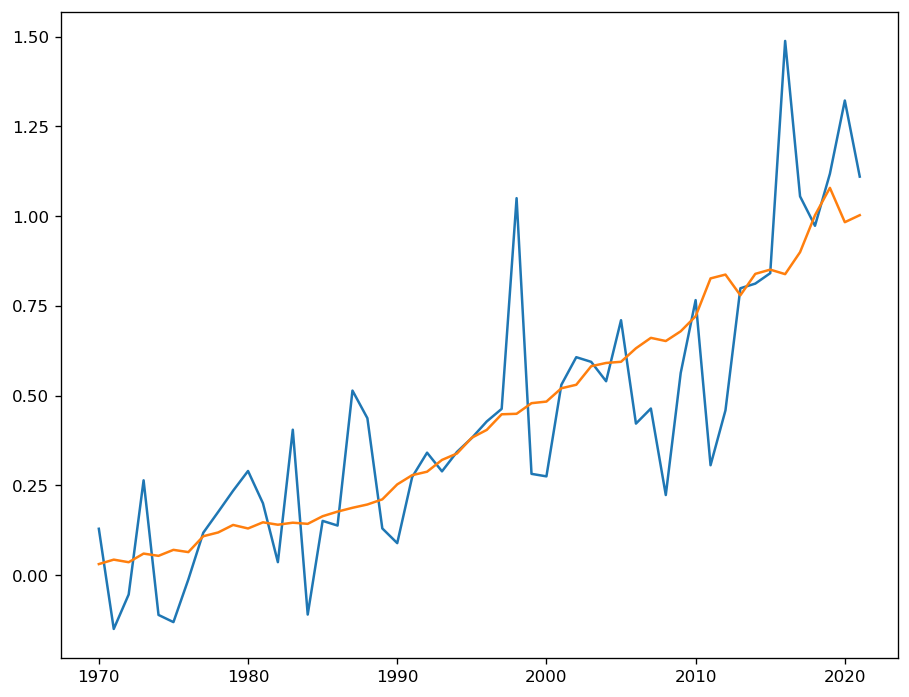

In [167]:
plt.plot(models[best_country_rmse]["data"].Temperature)
plt.plot(models[best_country_rmse]["data"].index,  models[best_country_rmse]["model"].forecast(steps=52, exog=models[best_country_rmse]["data"].Co2))